<a href="https://colab.research.google.com/github/smaranjitghose/CourseMiner/blob/main/CourseMiner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Course Miner

- A simple browser agent

## ⏬ Install Dependencies and Setup Browser Drivers

In [1]:
!pip install openai playwright pydantic nest_asyncio dotenv
!playwright install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 15.3 MB/s eta 0:00:00
164.9 MiB [] 0% 0.0s164.9 MiB [] 0% 7.1s164.9 MiB [] 0% 4.4s164.9 MiB [] 1% 3.1s164.9 MiB [] 2% 2.6s164.9 MiB [] 3% 2.5s164.9 MiB [] 4% 2.2s164.9 MiB [] 5% 2.0s164.9 MiB [] 6% 1.9s164.9 MiB [] 6% 2.1s164.9 MiB [] 7% 2.1s164.9 MiB [] 9% 1.9s164.9 MiB [] 10% 1.9s164.9 MiB [] 11% 1.8s164.9 MiB [] 13% 1.7s164.9 MiB [] 13% 1.8s164.9 MiB [] 14% 1.7s164.9 MiB [] 15% 1.6s164.9 MiB [] 17% 1.6s164.9 MiB [] 18% 1.5s164.9 MiB [] 19% 1.5s164.9 MiB [] 20% 1.4s164.9 MiB [] 21% 1.4s164.9 MiB [] 23% 1.3s164.9 MiB [] 24% 1.3s164.9 MiB [] 25% 1.3s164.9 MiB [] 26% 1.2s164.9 MiB [] 27% 1.3s164.9 MiB [] 29% 1.3s164.9 MiB [] 30% 1.2s164.9 MiB [] 31% 1.2s164.9 MiB [] 32% 1.2s164.9 MiB [] 33% 1.2s164.9 MiB [] 34% 1.1s164.9 MiB [] 35% 1.1s164.9 MiB [] 36% 1.1s164.9 MiB [] 37% 1.1s164.9 MiB [] 38% 1.1s164.9 MiB [] 39% 1.1s164.9 MiB [] 40% 1.1s164.9 MiB [] 42% 1.0s164.9 MiB [] 43% 1.0s164.9 MiB [] 44% 1.0s164.9 MiB [] 45% 1.0s164.9 MiB

## 🏗️ Import Dependences

In [2]:
import asyncio
import nest_asyncio
from pydantic import BaseModel
from typing import List
from playwright.async_api import async_playwright

## 🤫 Load Environment Vairables

In [95]:
# For Script
from dotenv import load_dotenv
import os

load_dotenv()
API_KEY = os.getenv("API_KEY")

In [96]:
# For Colab

from google.colab import userdata
API_KEY = userdata.get('OPENAI_API_KEY')

## 🔌 Intialize LLM Connection

In [98]:
from openai import OpenAI
client = OpenAI(api_key=API_KEY)

In [5]:
# Patch event loop for Jupyter/IPython environments
nest_asyncio.apply()

## ⚙️ Helper Functions

In [85]:
import base64
from IPython.display import display, HTML, Markdown

async def visualize_results(result, screenshot, target_url, instructions, base_url, model_name=None):
    """
    Dynamically visualize results from any Pydantic model

    Args:
        result: The scraped data result
        screenshot: Binary screenshot data
        target_url: URL that was scraped
        instructions: Scraping instructions
        base_url: Base URL for the website
        model_name: Optional custom name for the model (defaults to "Item")
    """
    if not result:
        display(Markdown("### No data was scraped."))
        return

    # Dynamically determine the collection attribute and items
    collection_attr = None
    items = None

    # Try to find the collection attribute
    for attr in dir(result):
        # Skip private attributes and methods
        if attr.startswith('_') or callable(getattr(result, attr)):
            continue

        value = getattr(result, attr)
        if isinstance(value, list) and len(value) >= 0:
            collection_attr = attr
            items = value
            break

    if not collection_attr or not items:
        display(Markdown("### Result structure not recognized. No collection found."))
        return

    # Get a readable name for the collection
    item_type = model_name or collection_attr.rstrip('s').capitalize()

    # Convert items to dictionaries
    try:
        # Try Pydantic v2 method first
        items_data = [item.model_dump() for item in items]
    except AttributeError:
        try:
            # Fall back to Pydantic v1 method
            items_data = [item.dict() for item in items]
        except AttributeError:
            # Last resort if not a Pydantic model
            items_data = [{k: v for k, v in vars(item).items()
                          if not k.startswith('_')} for item in items]

    # Process URLs for any URL fields
    for item in items_data:
        for key, value in item.items():
            # Look for URL fields that might need the base_url
            if isinstance(value, str) and (key.lower().endswith('url') or
                                         key.lower().endswith('link') or
                                         key.lower().endswith('uri')):
                if value and not value.startswith(('http://', 'https://')):
                    # Make it a clickable link
                    title = item.get('title', item.get('name', 'Link'))
                    full_url = f"{base_url}{value}"
                    item[key] = f'<a href="{full_url}" target="_blank">{title}</a>'

    # Build HTML table
    if items_data:
        headers = items_data[0].keys()
        table_html = '<table style="border-collapse: collapse; width: 100%;">'
        table_html += '<thead><tr>'

        for header in headers:
            # Format header for display (capitalize, replace underscores)
            display_header = header.replace('_', ' ').title()
            table_html += (
                f'<th style="border: 1px solid #dddddd; text-align: left; padding: 8px;">{display_header}</th>'
            )

        table_html += '</tr></thead><tbody>'

        for item in items_data:
            table_html += '<tr>'

            for header in headers:
                value = item[header]

                # Handle different field types
                if isinstance(value, str) and (
                    header.lower().endswith('image') or
                    header.lower().endswith('img') or
                    header.lower().endswith('imageurl')
                ):
                    # Handle image URLs
                    if not value.startswith(('http://', 'https://')):
                        value = f"{base_url}{value}"
                    value = f'<img src="{value}" alt="Image" style="max-width:100px; height:auto;">'
                elif isinstance(value, list):
                    # Handle lists by joining with commas
                    value = ', '.join(str(v) for v in value)
                elif isinstance(value, dict):
                    # Format dictionaries
                    value = str(value)

                table_html += (
                    f'<td style="border: 1px solid #dddddd; text-align: left; padding: 8px;">{value}</td>'
                )

            table_html += '</tr>'

        table_html += '</tbody></table>'
    else:
        table_html = f"<p>No {item_type} data available.</p>"

    # Display table with appropriate title
    display(Markdown(f"### Scraped {item_type} Data:"))
    display(HTML(table_html))

    # Display screenshot
    if screenshot:
        img_b64 = base64.b64encode(screenshot).decode('utf-8')
        img_html = (
            f'<img src="data:image/png;base64,{img_b64}" '
            f'alt="Website Screenshot" style="max-width:100%; height:auto;">'
        )
        display(Markdown("### Website Screenshot:"))
        display(HTML(img_html))

In [56]:
def get_course_req(course):
    field_names = []
    try:
        # Pydantic v2 approach
        if hasattr(course, "__annotations__"):
            field_names = list(course.__annotations__.keys())
        # Pydantic v1 approach
        elif hasattr(course, "__fields__"):
            field_names = list(course.__fields__.keys())
    except Exception as e:
        print(f"Error extracting field names: {str(e)}")
    field_list = ", ".join(field_names)
    return field_list

## 🔭 Web Scraper

In [88]:
class WebScraper:
    def __init__(self):
        self.playwright = None
        self.browser = None
        self.page = None

    async def init_browser(self):
        if self.browser is not None:
            return
        self.playwright = await async_playwright().start()
        self.browser = await self.playwright.chromium.launch(
            headless=True,
            args=[
                "--disable-dev-shm-usage",
                "--no-sandbox",
                "--disable-setuid-sandbox",
                "--disable-accelerated-2d-canvas",
                "--disable-gpu",
                "--no-zygote",
                "--disable-audio-output",
                "--disable-software-rasterizer",
                "--disable-webgl",
                "--disable-web-security",
                "--disable-features=LazyFrameLoading",
                "--disable-features=IsolateOrigins",
                "--disable-background-networking"
            ]
        )
        self.page = await self.browser.new_page()

    async def scrape_content(self, url):
        if not self.page or self.page.is_closed():
            await self.init_browser()
        await self.page.goto(url, wait_until="load")
        await self.page.wait_for_timeout(2000)  # wait for dynamic content
        return await self.page.content()

    async def screenshot_buffer(self):
        return await self.page.screenshot(type="png", full_page=False)

    async def close(self):
        if self.browser:
            await self.browser.close()
        if self.playwright:
            await self.playwright.stop()
        self.browser = None
        self.playwright = None
        self.page = None

## 🧠 LLM Analysis

In [90]:
async def process_with_llm(html, base_url, course, course_list, instructions):
    # Customizable System Prompt
    system_prompt = f"""
                You are an expert web scraping agent. Your task is to:
                Extract relevant information from this HTML to JSON
                following these instructions:
                {instructions}


                Extract the {get_course_req(course)} for each of
                all the courses for the {base_url} website.

                Return ONLY valid JSON, no markdown or extra text.
                """
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {
                "role": "system","content": system_prompt },
            {
                "role": "user","content": html[:150000]
            }
        ],
        temperature=0.1,
        response_format=course_list,
    )
    return completion.choices[0].message.parsed

## 🤖 Browser Agent

In [91]:
async def browser_agent(target_url, base_url, course, course_list, instructions):
    scraper = WebScraper()
    result = None
    try:
        print("🔍 Extracting HTML Content")
        html_content = await scraper.scrape_content(target_url)

        print("📸 Taking Screenshot")
        screenshot = await scraper.screenshot_buffer()

        print("🤖 Processing with LLM")
        result = await process_with_llm(html_content, base_url, course, course_list, instructions)
        print("✅ Done!")
    except Exception as e:
        print(f"❌ Error in webscraper: {str(e)}")
        raise
    finally:
        await scraper.close()

    return result, screenshot

## 🛝 Examples

### Experiment 1

In [7]:
# --- Pydantic Models ---
class DeeplearningCourse(BaseModel):
    title: str
    description: str
    presenter: List[str]
    imageUrl: str
    courseURL: str

class DeeplearningCourseList(BaseModel):
    courses: List[DeeplearningCourse]

In [66]:
target_url = "https://www.deeplearning.ai/courses/"
base_url="https://deeplearning.ai"

instructions = """
    Get all the courses
"""

# Run the webscraper and display results
result, screenshot = await browser_agent(target_url, base_url,DeeplearningCourse,DeeplearningCourseList, instructions)

🔍 Extracting HTML Content
📸 Taking Screenshot
🤖 Processing with LLM
✅ Done!


### Scraped Course Data:

title,description,presenter,imageUrl,courseURL
Building AI Browser Agents,"Build agents that navigate and interact with websites, and learn how to make them more reliable.",AGI Inc,,Building AI Browser Agents
Getting Structured LLM Output,Learn how to generate structured outputs to power production-ready LLM software applications.,DotTxt,,Getting Structured LLM Output
Vibe Coding 101 with Replit,"Design, build, and deploy apps with an AI coding agent in an integrated web development environment.",Replit,,Vibe Coding 101 with Replit
Data Analytics Professional Certificate,"Build a solid data analytics foundation using industry standard and AI tools to extract insights, make decisions, and solve real-world business problems.",DeepLearning.AI,,Data Analytics Professional Certificate
Long-Term Agentic Memory with LangGraph,"Learn to build AI agents with long-term memory with LangGraph, using LangMem for memory management.",LangChain,,Long-Term Agentic Memory with LangGraph
Event-Driven Agentic Document Workflows,Build an event-driven agentic workflow to process documents and fill forms using RAG and human-in-the-loop feedback.,LlamaIndex,,Event-Driven Agentic Document Workflows
Build Apps with Windsurf’s AI Coding Agents,"Learn to build, debug, and deploy applications with an Agentic AI-powered integrated development environment.",Windsurf,,Build Apps with Windsurf’s AI Coding Agents
Evaluating AI Agents,"Learn how to systematically evaluate, improve, and iterate on AI agents using structured assessments.",Arize AI,,Evaluating AI Agents
Attention in Transformers: Concepts and Code in PyTorch,"Understand and implement the attention mechanism, a key element of transformer-based LLMs, using PyTorch.",StatQuest,,Attention in Transformers: Concepts and Code in PyTorch
How Transformer LLMs Work,Understand the transformer architecture that powers LLMs to use them more effectively.,"Jay Alammar, Maarten Grootendorst",,How Transformer LLMs Work


### Website Screenshot:


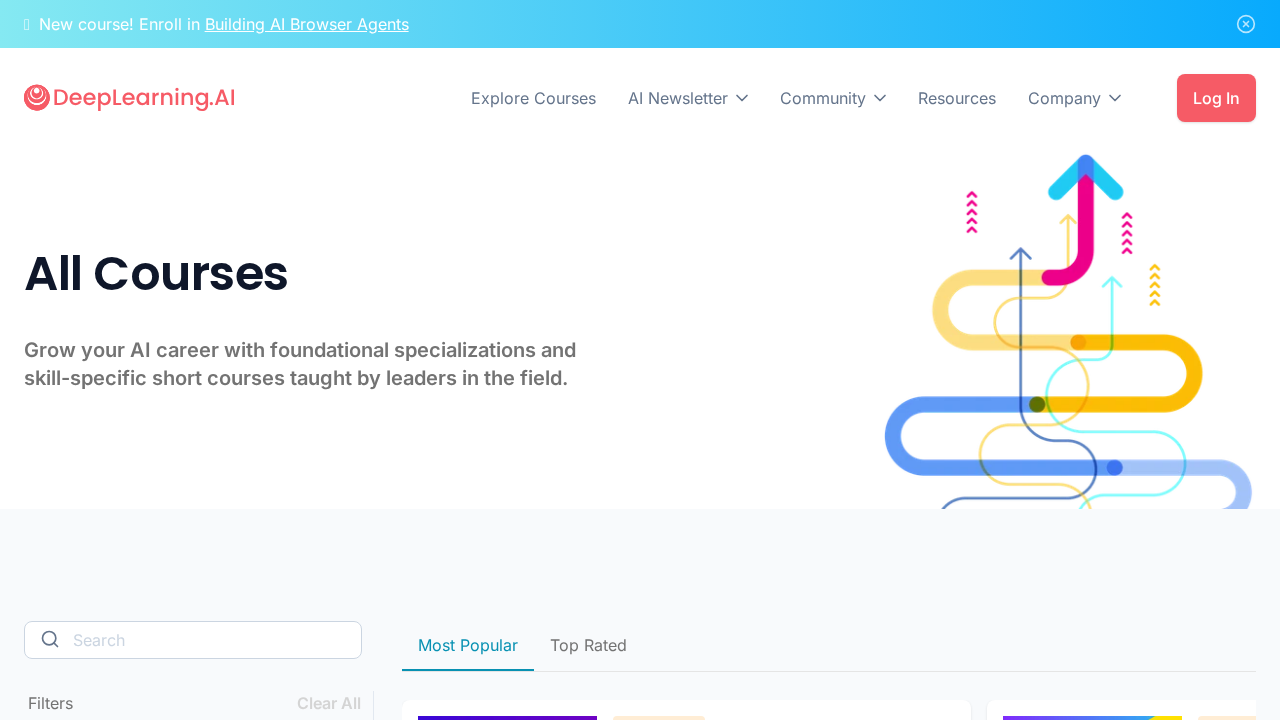

In [69]:
await visualize_results(result, screenshot, target_url, instructions, base_url)

In [70]:
subject = "AI Agents"

instructions = f"""
Read the description of the courses and only provide the courses that are about {subject}.
Make sure that we don't have any other courses in the output.
"""
result, screenshot = await browser_agent(target_url, base_url,DeeplearningCourse,DeeplearningCourseList, instructions)

🔍 Extracting HTML Content
📸 Taking Screenshot
🤖 Processing with LLM
✅ Done!


### Scraped Course Data:

title,description,presenter,imageUrl,courseURL
Building AI Browser Agents,"Build agents that navigate and interact with websites, and learn how to make them more reliable.",AGI Inc,,Building AI Browser Agents
Multi AI Agent Systems with crewAI,Automate business workflows with multi-AI agent systems. Exceed the performance of prompting a single LLM by designing and prompting a team of AI agents through natural language.,crewAI,,Multi AI Agent Systems with crewAI
Evaluating AI Agents,"Learn how to systematically evaluate, improve, and iterate on AI agents using structured assessments.",Arize AI,,Evaluating AI Agents
LLMs as Operating Systems: Agent Memory,Build systems with MemGPT agents that can autonomously manage their memory.,Letta,,LLMs as Operating Systems: Agent Memory
Practical Multi AI Agents and Advanced Use Cases with crewAI,Build agents that collaborate to solve complex business tasks.,crewAI,,Practical Multi AI Agents and Advanced Use Cases with crewAI


### Website Screenshot:


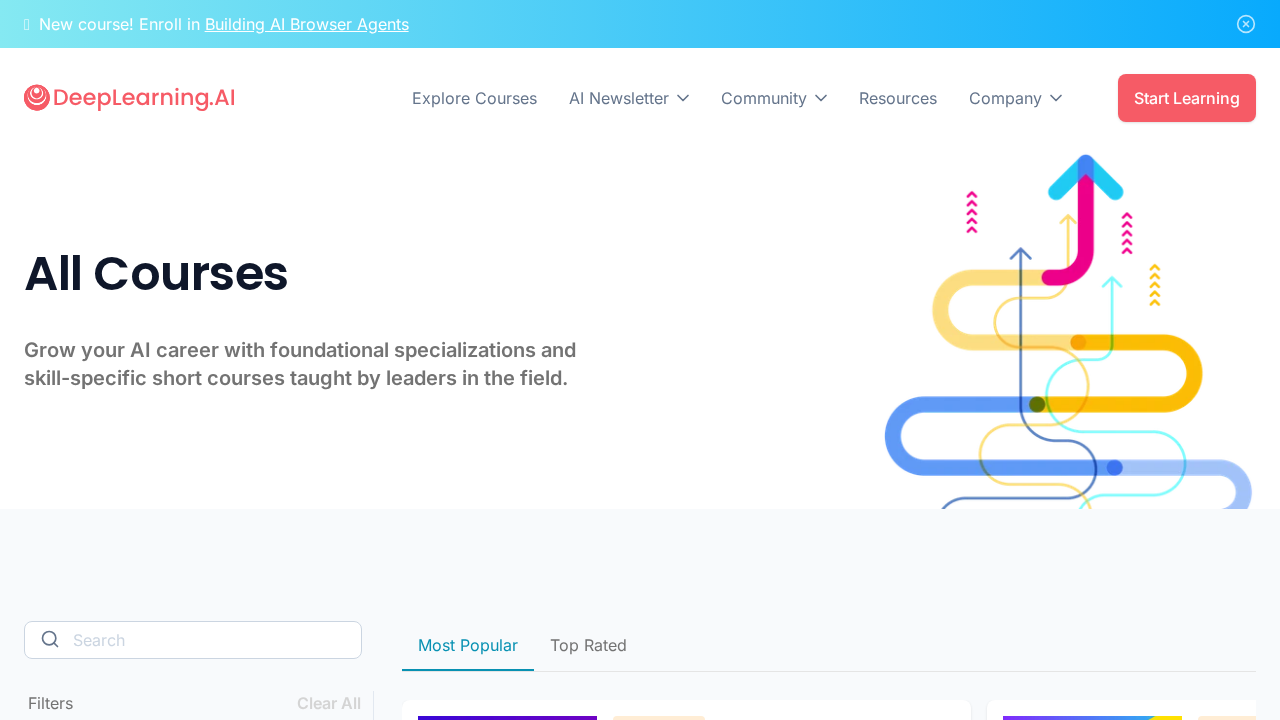

In [71]:
await visualize_results(result, screenshot, target_url, instructions, base_url)

### Experiment 2

In [74]:
# --- Pydantic Models ---
class NPTELCourse(BaseModel):
    title: str
    subject: str
    instructors: List[str]
    institution: str
    course_url: str

class NPTELCourseList(BaseModel):
    courses: List[NPTELCourse]

In [82]:
target_url = "https://nptel.ac.in/courses"
base_url = "https://nptel.ac.in"
instructions = """Get all the courses"""

# Run the webscraper and display results
result, screenshot = await browser_agent(target_url, base_url,NPTELCourse,NPTELCourseList, instructions)

🔍 Extracting HTML Content
📸 Taking Screenshot
🤖 Processing with LLM
✅ Done!


### Scraped Course Data:

Title,Subject,Instructors,Institution,Course Url
Introduction to Aerospace Propulsion,Aerospace Engineering,"Prof. Bhaskar Roy, Prof. A M Pradeep",IIT Bombay,Introduction to Aerospace Propulsion
Jet Aircraft Propulsion,Aerospace Engineering,"Prof. Bhaskar Roy, Prof. A M Pradeep",IIT Bombay,Jet Aircraft Propulsion
Turbomachinery Aerodynamics,Aerospace Engineering,"Prof. Bhaskar Roy, Prof. A M Pradeep",IIT Bombay,Turbomachinery Aerodynamics
NOC:Introduction to Aerospace Engineering,Aerospace Engineering,Prof. Rajkumar Pant,IIT Bombay,NOC:Introduction to Aerospace Engineering
NOC:Introduction to Aircraft Design,Aerospace Engineering,Prof. Rajkumar Pant,IIT Bombay,NOC:Introduction to Aircraft Design
NOC:Introduction to Launch Vehicle Analysis and Design,Aerospace Engineering,Prof. Ashok Joshi,IIT Bombay,NOC:Introduction to Launch Vehicle Analysis and Design
NOC:Lighter than Air Systems,Aerospace Engineering,Prof. Rajkumar Pant,IIT Bombay,NOC:Lighter than Air Systems
NOC:Elements Of Mechanical Vibration,Aerospace Engineering,Prof. Ashish K Darpe,IIT Delhi,NOC:Elements Of Mechanical Vibration
Hypersonic Aerodynamics,Aerospace Engineering,"Dr. N. Sahoo, Dr. Vinayak Kulkarni",IIT Guwahati,Hypersonic Aerodynamics
Principles of Fluid Dynamics,Aerospace Engineering,"Dr. N. Sahoo, Dr. Vinayak Kulkarni",IIT Guwahati,Principles of Fluid Dynamics


### Website Screenshot:


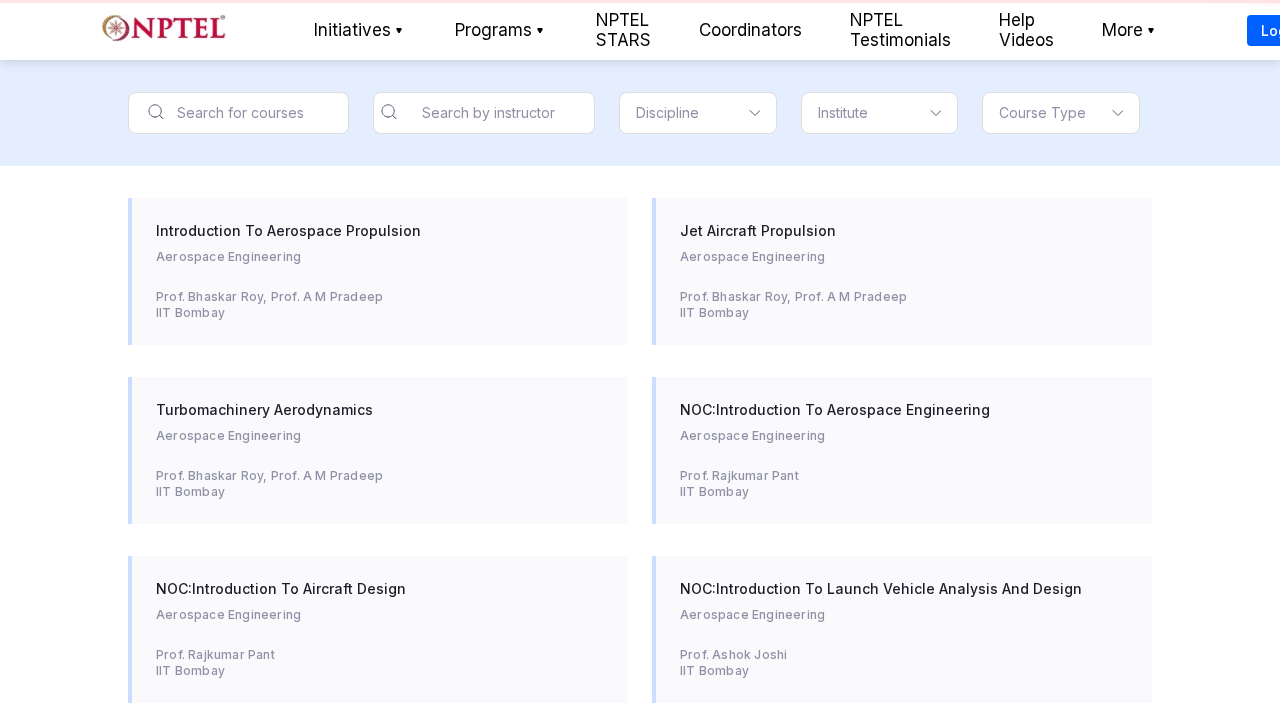

In [86]:
await visualize_results(result,screenshot,target_url,instructions,base_url)